In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db= mysql.connector.connect(host="localhost",
                            username="root",
                            password="Shiva@123",
                            database="ecommerce")
cur=db.cursor()


List all unique cities where customers are located.


In [30]:
query= """ SELECT distinct customer_city from customers """ 

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#count the number of orders placed in 2017

In [3]:
query= """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """ 

cur.execute(query)
data=cur.fetchall()
"total order placed in 2017 are",data[0][0]

('total order placed in 2017 are', 90202)

Find the total sales per category.

In [ ]:
query= """SELECT upper(products.product_category) AS category,
       round(SUM(payments.payment_value),2) AS sales
FROM products
JOIN order_items
  ON products.product_id = order_items.product_id
JOIN payments
  ON payments.order_id = order_items.order_id
GROUP BY products.product_category;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","Sales"])
df

,category,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


Calculate the prercentage of orders that were paod in installments

In [5]:
query= """ SELECT (SUM(
    CASE 
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END))/count(*)*100 
FROM payments;
"""
cur.execute(query)
data=cur.fetchall()
"the percentage of order that were paid in installment is",data[0][0]

('the percentage of order that were paid in installment is',
 Decimal('99.9981'))

Count the number of customers from each state.

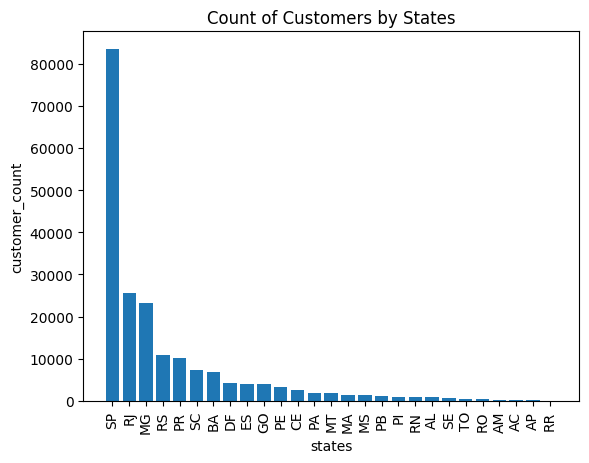

In [45]:
query= """ SELECT customer_state , count(customer_id)
FROM customers group by customer_state
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["state","customer_count"])
df=df.sort_values(by="customer_count",ascending=False)

plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation =90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()


Calculate the Number of orders per months 2018.

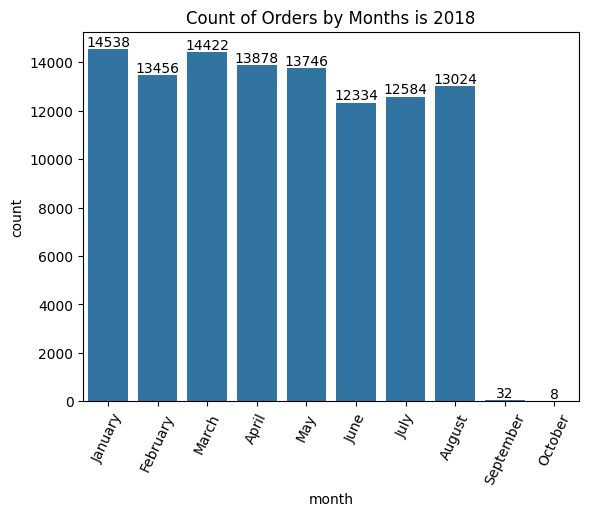

In [46]:
query= """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by months
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["month","count"])
o=["January", "February", "March", "April",
    "May", "June", "July", "August",
    "September", "October"]

ax=sns.barplot(x=df["month"],y=df["count"],data=df,order=o)
ax.bar_label(ax.containers[0])
plt.xticks(rotation=65)
plt.title("Count of Orders by Months is 2018")
plt.show()


Find the average number of products per order, grouped by customer city.

In [12]:
query= """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on  orders.order_id= order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id =count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""
cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data,columns=["Customer City","Average product/Orders"])
df.head(10)

,Customer City,Average product/Orders
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


Calculate the percentage of total revenue  contributed by each product category

In [15]:
query= """SELECT upper(products.product_category) AS category,
       round((SUM(payments.payment_value)/(select sum(payment_value) from payments))*100,2) AS sales_percentage
FROM products
JOIN order_items
  ON products.product_id = order_items.product_id
JOIN payments
  ON payments.order_id = order_items.order_id
GROUP BY category order by sales_percentage desc;
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","sales_percentage"])
df

,category,sales_percentage
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
...,...,...
69,PC GAMER,0.03
70,HOUSE COMFORT 2,0.02
71,CDS MUSIC DVDS,0.01
72,FASHION CHILDREN'S CLOTHING,0.01


Identify the correlation between product price and the number of times a product has been purchased.

In [ ]:
query= """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id= order_items.product_id
group by products.product_category;

"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["category","order_count","price"])

arr1= df["order_count"]
arr2= df["price"]

a=np.corrcoef([arr1,arr2])
print("The correlation between price and number of times a product has been purchase is",a[0][1])



The correlation between price and number of times a product has been purchase is -0.10631514167157562


Calculate the total revenue generate by each seller and ranking by revenue.

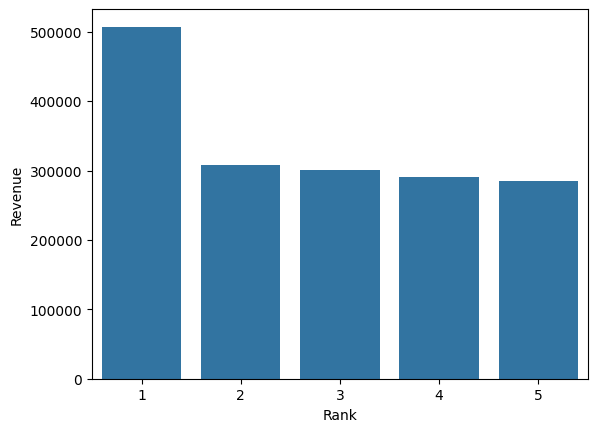

In [28]:
query= """ select *,dense_rank() over(order by revenue desc) as ar from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","Revenue","Rank"])
df=df.head()
sns.barplot(x="Rank",y="Revenue",data=df)
plt.show()


Calcilate the moving average of order values for each customer over their order history.

In [36]:
query= """ select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(SELECT orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id= orders.order_id) as a;
"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["customer_id","order_purchase_timestamp"," payment","mov_avg"])
df
# (data,columns=["order_purchase_timestamp"," payment","mov_avg"])

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


Calculate the cummulative sales per month for each year.

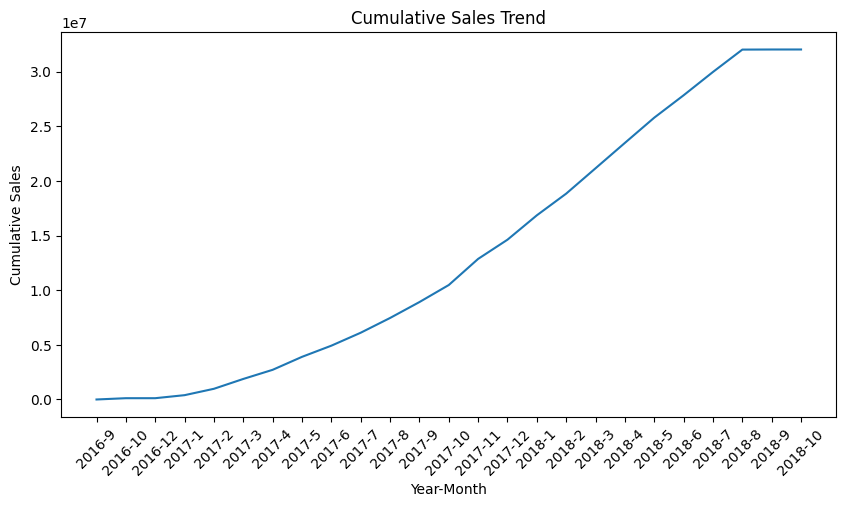

In [40]:
query= """select years, months, sum(payment)
over(order by years,months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
ON orders.order_id= payments.order_id
group by years, months order by years, months) as a;
"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=["Years","Months","cumulative_sales"])

df["Year_Month"] = df["Years"].astype(str) + "-" + df["Months"].astype(str)

plt.figure(figsize=(10,5))
plt.plot(df["Year_Month"], df["cumulative_sales"])
plt.xticks(rotation=45)
plt.xlabel("Year-Month")
plt.ylabel("Cumulative Sales")
plt.title("Cumulative Sales Trend")
plt.show()

Calculate the year-over-year growth rate of total sales.


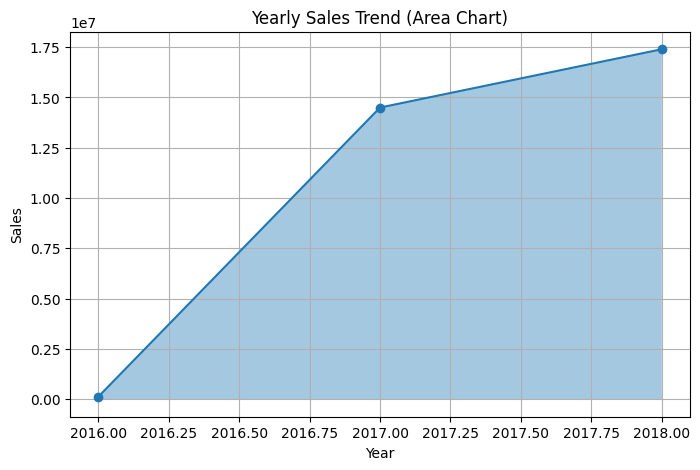

In [56]:
query= """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
ON orders.order_id= payments.order_id
group by years order by years)

select years, payment, lag(payment, 1) over(order by years) from a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data=data, columns=["Years","Sales","pre_year"])

plt.figure(figsize=(8,5))
plt.fill_between(df["Years"], df["Sales"], alpha=0.4)
plt.plot(df["Years"], df["Sales"], marker='o')

plt.xlabel("Year")
plt.ylabel("Sales")
plt.title("Yearly Sales Trend (Area Chart)")
plt.grid(True)
plt.show()


Calculate the retention rate of customer , defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [57]:
query= """with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id =orders.customer_id 
group by customers.customer_id),

b as(select a.customer_id, count(distinct orders.order_purchase_timestamp)
FROM a join orders
on orders.customer_id= a.customer_id
and orders.order_purchase_timestamp> first_order
and orders.order_purchase_timestamp<
date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count( distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id= b.customer_id ;

"""
cur.execute(query)
data=cur.fetchall()
data

[(None,)]

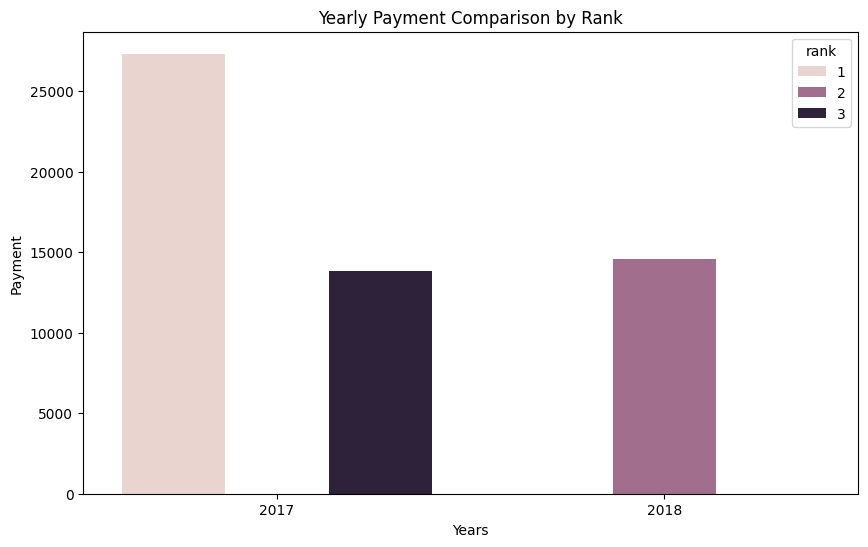

In [61]:
query= """select years, customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id=orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <=3 ;"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data=data, columns=["Years","ID","Payment","rank"])


plt.figure(figsize=(10,6))

sns.barplot(
    data=df,
    x="Years",
    y="Payment",
    hue="rank"
)

plt.title("Yearly Payment Comparison by Rank")
plt.show()